## Figure notebook for annotating multiomic (RNA+CITE-seq) datasets (from neurips 2021, S1D1 cite)

Last updated: 1/11/2023

Author: Yang-Joon Kim

Notse: 
- We will use the neurips 2021, s1d1 (RNA+CITE) objects - both RNA and ADT modalities(assays)
- Note that the adata.X is normalized differently for RNA and ADT (RNA is log-normalized, whereas ADT is centered-log-ratio transformed). Raw counts are saved in the "counts" layer.
- We will use a subset of cell-types for UMAP visualizations for simplicity
- [NOT DONE YET] We will generate the whole figure using matplotlib (following Jonathan's Jupyter notebooks).


In [2]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
#from skimage.measure import block_reduce
import tifffile
import string
from sklearn.metrics import confusion_matrix

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
    
def set_plotting_style_huge():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=24)
    plt.rc('axes', titlesize=24)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=20)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=4)
    plt.rc('ytick.major', pad=4)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [4]:
# load utilities module
import sys
sys.path.append("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/utilities/")
import color_schema

In [5]:
# define the figure path
figpath = "/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/figures/Figure_RNA_CITE_multiome/"
sc.settings.figdir = figpath
set_plotting_style()

## Figure scheme

- (A): 
- (B): 
- (C): 
- (D):
- (E):


In [6]:
# marker genes for RNA
marker_genes = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'FOS', 'JUN', 'EGR1', 'KLF4', 'PLAUR'],
    'cDC1': ['CLEC9A', 'CADM1'],
    'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'], # TFRC negative
    'Normoblast': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],  # TFRC positive
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers   # CRACD as well, but not present in data
    'NK': ['GNLY', 'NKG7', 'CD247', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'], # GRIK4 as well, but not present in data
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],  # new: STMN1
    'Naive CD20+ B - IGKC+':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'],
    'Naive CD20+ B - IGKC-':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'], # IGKC negative
    'B1 B - IGKC+':['MS4A1', 'SSPN', 'ITGB1','IGKC', 'EPHA4', 'COL4A4', 'PRDM1', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'],# Note IGHD and IGHM are negative markers #ZNF215 not in data
    'B1 B - IGKC-':['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 'PRDM1', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM', 'IGKC'],# Note IGKC, IGHD and IGHM are negative markers #ZNF215 not in data
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cell': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'Plasmablast': ['XBP1', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker   # RF4 as well, but not present in data
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
    'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'T activation': ['CD69', 'CD38'], # CD69 much better marker!
    'T naive': ['LEF1', 'CCR7', 'TCF7'],
    'T reg': ['FOXP3'],
    'Effector CD4+ T': ['KLRB1', 'CD4', 'PDCD1', 'TNF'],
    'Effector CD8+ T': ['KLRK1', 'GZMH', 'CD8A', 'CD8B'],
    'MAIT': ['KLRB1', 'CD8A', 'GZMK', 'IL7R'],
    'gdT': ['KLRC2', 'KLRF1', 'FCGR3A', 'GZMB', 'GZMH'],
    'pDC': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'], 
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'], 
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'PLCB1'], # 'RYR3' as well,  but not present in data
}


In [9]:
# markers for ADT
high_level_markers = {
    'Erythro linage' : ['CD71'],
    'CD4+ T' : ['CD4'],
    'CD8+ T' : ['CD8'],
    'B': ['CD40', 'CD19'],
    'Mono':['CD11b'],
    'Progen':['CD112']
}

marker_prots = {
    
    'CD14+ Mono': ['CD14', 'CD11b', 'CD62P'],
    'CD16+ Mono': ['CD85j', 'CD11c', 'CD172a', 'CD88'],
    'cDC2': ['CD1c', 'FceRIa', 'CD11c'],
    'pDC': ['CD303', 'CD304'], 
    
    #Ery linage
    'Proerythroblast': ['CD105'],
    'Erythroblast': ['CD82', 'CD71'], # CD82 also in B
    'Normoblast/Reticulocyte': ['CD71'], 

    # B linage
    'naive CD20+ B': ['IgD'],
    'B1 B': ['CD40', 'CD35', 'CD268', 'IgD'], # (IgD- !)
    'transitional B': ['CD38', 'CD24'], # 'CD24', 'CD81', 'CD9'
    'Plasma cell': ['CD63', 'CD319'], 
    'Plasmablast': ['CD39', 'CD319'], # CD86
    
    #NK
    'NK': ['CD56', 'CD94', 'CD335'],  # 'CD57'?
    'NK CD158e1+':['CD158e1'],
    
    # Progenitors
    'MK/E prog':['CD105', 'CD112', 'CD352'],
    'HSC': ['CD112', 'CD13', 'CD155'],
    'Lymph prog':['CD112', 'CD81'], # close to HSC
    'G/M prog':['CD112', 'CD86'],
    
    #CD4
    'CD4+ T naive':['CD45RA','CD4'], # close to HSC
    'T reg':['CD25', 'CD39', 'CD4'],
    'CD4+ T activated':['CD45RO','CD4'], # none of CD279+, CD194+, integrinB7+, CD314+
    'CD4+ T activated CD279+':['CD279','CD45RO','CD4', 'CD25'], #CD25 negative
    'CD4+ T activated CD194+':['CD194','CD45RO','CD4'],
    'CD4+ T activated integrinB7+':['integrinB7','CD45RO','CD4'],
    'CD4+ T CD314+ CD45RA+':['CD11c','CD314','CD45RA','CD4'], # 'CD11c' negative
    
    # CD8, gdT and other
    'CD8+ T naive CD127+ CD26+ CD101+':['CD127','CD26','CD101','CD45RA','CD8'],
    'CD8+ T naive CD127+ CD26- CD101-':['CD127','CD26','CD101','CD45RA','CD8'],
    
    'ILC1':['CD103', 'CD127'],
    'MAIT':['TCRVa7.2', 'CD8'],
    'gdT TCRVD2+':['TCRVd2','CD161'],
    
    'gdT CD56+':['CD56','CD158b'],
    'gdT Vd1 CD57+':['CD57','CD158b'],
    'gdT CD158b+ CD11c+':['CD158b','CD11c'],
    
    'CD8 T CD49f+':['CD49f','CD226', 'CD45RO'], # only CD45RO+
    'CD8 T CD57+ CD45RO+':['CD57', 'CD45RO'], # CD56-
    'CD8 T CD57+ CD45RA+':['CD57','CD56', 'CD45RA'],
    'CD8 T TIGIT+ CD45RO+':['TIGIT','CD45RO'], # also CD226-
    'CD8 T TIGIT+ CD45RA+':['TIGIT','CD45RA'], #
    'CD8 T CD69+ CD45RO+':['CD69','CD45RO'], # also CD226-
    'CD8 T CD69+ CD45RA+':['CD69','CD45RA'], # 
}

In [10]:
marker_genes["CD4+ T activated"]
marker_genes["CD4+ T naive"]

['CD4', 'IL7R', 'TRBC2', 'CCR7']

# UMAP plots with different labels/annotations

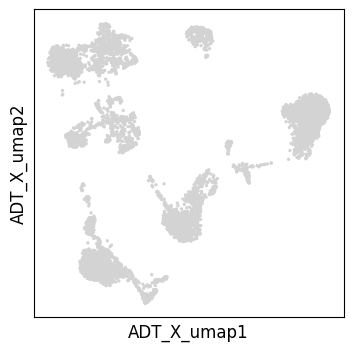

In [99]:
# plot the UMAP without any labels
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata, basis="ADT_X_umap" ,legend_fontsize=8, save="_ADT_no_color.pdf")

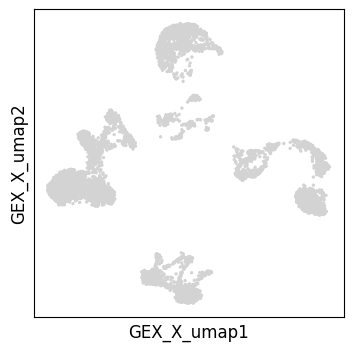

In [98]:
# plot the UMAP without any labels
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata, basis="GEX_X_umap" ,legend_fontsize=8,save="_RNA_no_color.pdf")

# Leiden clustering on GEX and ADT

- We performed leiden clustering on exCellxgene for GEX and ADT, respectively. Then, we exported the clustering results to adata.obs with different resolutions.
- We will use the leiden resolution of 0.01 as that gave us reasonable number of clusters for the initial inspectioin of the data.



In [242]:
adata_leiden = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_cite/ADT_X_umap.h5ad")
adata_leiden

AnnData object with n_obs × n_vars = 5227 × 14087
    obs: 'name_0', 'name_1', 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'manual_annotation', 'coarse_annotation', 'leiden_v1_r1', 'leiden_v2_r1', 'leiden_v3_r0.1', 'leiden_v4_r0.05', 'leiden_v5_r0.05', 'leiden_ADT_005', 'leiden_GEX_005', 'leiden_v6_r0.02', 'leiden_v7_r0.01', 'leiden_v8_r0.01', 'leiden_GEX_001', 'leiden_ADT_001'
    var: 'name_0', 'name_1', 'feature_types', 'mean', 'variance'
    obsm: 'X_ADT_X_pca', 'X_ADT_X_umap', 'X_GEX_X_pca', 'X_GEX_X_umap', 'X_latent_ADT_X_pca', 'X_latent_GEX_X_pca', 'X_latent_latent_ADT_X_pca', 'X_latent_latent_GEX_X_pca'
    layers: 'X',

In [243]:
adata.obs["leiden_GEX_001"] = adata_leiden.obs["leiden_GEX_001"]
adata.obs["leiden_ADT_001"] = adata_leiden.obs["leiden_ADT_001"]

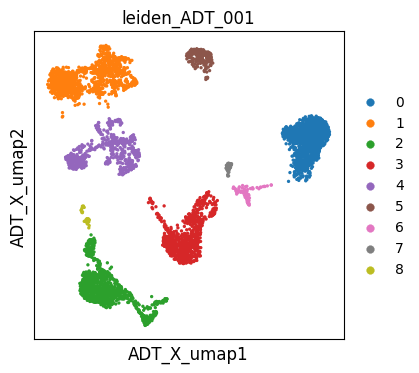

In [245]:
# ADT UMAP with leiden resolution of 0.01
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata, basis="ADT_X_umap", color="leiden_ADT_001",
                    save="_leiden_ADT_001.pdf")

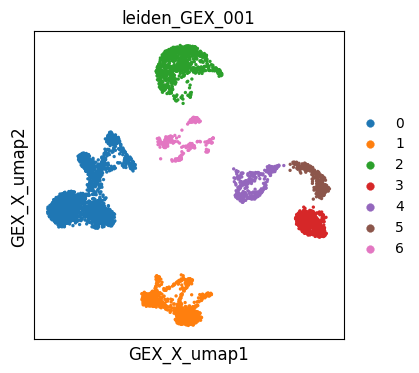

In [244]:
# GEX UMAP with leiden resolution of 0.01
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata, basis="GEX_X_umap", color="leiden_GEX_001",
                    save="_leiden_GEX_001.pdf")

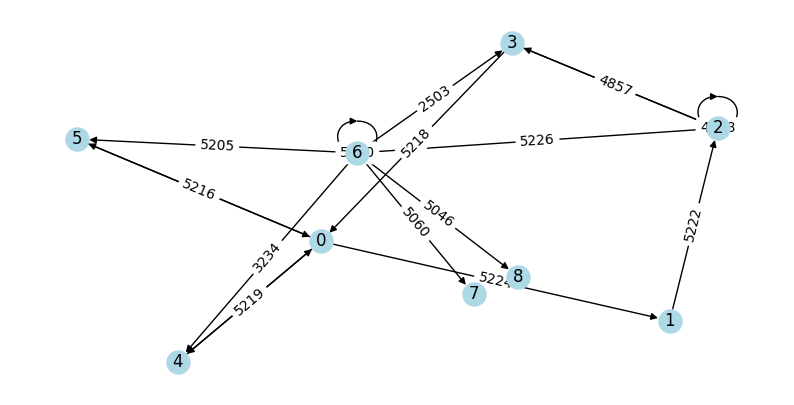

In [246]:
import matplotlib.pyplot as plt
import networkx as nx

label1 = "leiden_GEX_001"
label2 = "leiden_ADT_001"

def sankey_plot(data, label1, label2):
    G = nx.DiGraph()
    for i, (l1, l2) in enumerate(zip(data[label1], data[label2])):
        G.add_edge(l1, l2, weight=1, label=f'{i}')
    pos = nx.kamada_kawai_layout(G)
    fig, ax = plt.subplots(figsize=(10, 5))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', ax=ax)
    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
    plt.show()

sankey_plot(adata.obs, label1, label2)


In [248]:
import plotly.express as px
import pandas as pd

# Convert adata.obs to a Pandas DataFrame
df = adata.obs.reset_index()

label1 = "leiden_GEX_001"
label2 = "leiden_ADT_001"

# Create a Sankey diagram
fig = px.sankey(df, 
                dimensions=[label1, label2],
                values="index",
                color=label1,
                height=600,
                width=800)

# Show the diagram
fig.show()

AttributeError: module 'plotly.express' has no attribute 'sankey'

In [249]:
import plotly.graph_objects as go
import pandas as pd

# Convert adata.obs to a Pandas DataFrame
df = adata.obs.reset_index()

# Create a Sankey diagram
fig = go.Figure(data=[go.Sankey(node=dict(label=df[label1].append(df[label2]).drop_duplicates()),
                                link=dict(source=df.index.tolist()*2,
                                          target=df[label1].append(df[label2]).tolist(),
                                          value=df.index.tolist()*2))])

# Show the diagram
fig.show()


In [253]:
import plotly.graph_objects as go
import pandas as pd

# Convert adata.obs to a Pandas DataFrame
df = adata.obs.reset_index()

# Convert source and target to a Pandas DataFrame
df = pd.DataFrame({'source': adata.obs["leiden_GEX_001"], 'target': adata.obs["leiden_ADT_001"]})

# Count the number of occurrences of each source-target pair
df['value'] = df.groupby(['source', 'target']).size()

# Normalize the value to a scale of 1
df['value'] = df['value'] / df['value'].sum()

# # Subset the data to include only the desired number of edges
# df_subset = df.head(max_edges)

# Create a Sankey diagram
fig = go.Figure(data=[go.Sankey(node=dict(label=df["source"].append(df["target"]).drop_duplicates()),
                                link=dict(source=df.index.tolist()*2,
                                          target=df["source"].append(df["target"]).tolist(),
                                          value=df.index.tolist()*2))])

# Show the diagram
fig.show()


In [256]:
# Count the number of occurrences of each source-target pair
df['value'] = df.groupby(['source', 'target']).size()

# Normalize the value to a scale of 1
df['value'] = df['value'] / df['value'].sum()
df

source target  value
GCATTAGCATAAGCGG-1-s1d1      1      2    NaN
TACAGGTGTTAGAGTA-1-s1d1      2      3    NaN
AGGATCTAGGTCTACT-1-s1d1      1      2    NaN
GTAGAAAGTGACACAG-1-s1d1      0      1    NaN
TCCGAAAAGGATCATA-1-s1d1      3      0    NaN
...                        ...    ...    ...
GTCGAATAGTTTCGGT-1-s1d1      1      2    NaN
AGTAGTCTCTGGGCGT-1-s1d1      0      1    NaN
GCCCGAAGTATGGAGC-1-s1d1      0      1    NaN
CTACATTAGCGCGTTC-1-s1d1      2      3    NaN
GATTCTTTCACCCATC-1-s1d1      6      2    NaN

[5227 rows x 3 columns]

# Annotation/Exploration using exCellxgene - T cells and erythroblast populations only

- last updated: 1/13/2023

Here, the annotation was originally done for all fine-grained cell-types by the neurips annotation team.
For visualization, we will merge some fine-grained annotations to make a "coarse" annotation named "manual_annotation". (Basically, merging some sub-populations identified using the surface protein markers).
- Coarse - manual_annotation
- Fine - cell_type (done by the neurips annotators)

In [233]:
adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_cite/s1d1_gex_cite_joint_normalized_per_assay_reannotated.h5ad")
adata

AnnData object with n_obs × n_vars = 5227 × 14087
    obs: 'name_0', 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'manual_annotation', 'coarse_annotation'
    var: 'name_0', 'feature_types', 'mean', 'variance'
    obsm: 'X_ADT_X_pca', 'X_ADT_X_umap', 'X_GEX_X_pca', 'X_GEX_X_umap', 'X_latent_ADT_X_pca', 'X_latent_GEX_X_pca'
    layers: 'X', 'counts'

### marker genes for T-cell subtypes (RNA)

- 'CD4+ T': ['CD4', 'IL7R', 'TRBC2']
- 'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA']
- 'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1']
- 'NK': ['GNLY', 'NKG7', 'CD247', 'GRIK4', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A']

### marker genes for T-cell subtypes (ADT)
- 'CD4+ T': ['CD4']
- 'CD8+ T': ['CD8']
- 'ILC': ['CD103', 'CD127']
- 'NK': ['CD56','CD94', 'CD335']
- 'MAIT':['TCRVa7.2', 'CD8']


## markers that I chose for visualization and further exploration
- "CD4+ T": ["CD4-RNA", "CD4-ADT"]
- "CD8+ T": ["CD8A-RNA", "CD8-ADT"]
- "NK": ["GNLY-RNA","CD56-ADT"]

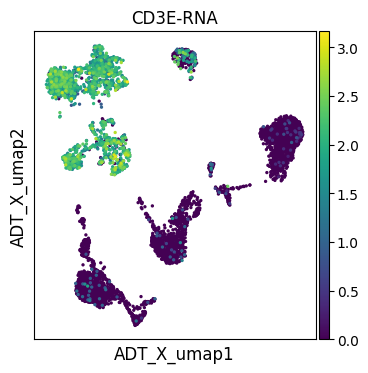

In [102]:
# marker for pan T-cell
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata, basis="ADT_X_umap", color="CD3E-RNA",
                    save="_CD3E-RNA.pdf")

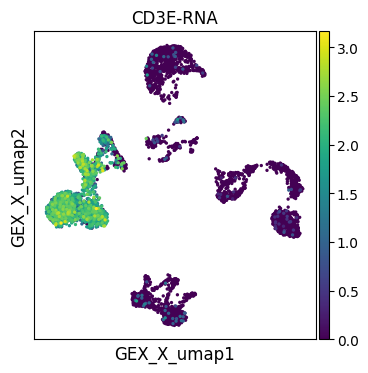

In [103]:
# marker for pan T-cell
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata, basis="GEX_X_umap", color="CD3E-RNA",
                    save="_CD3E-RNA.pdf")

In [33]:
# thresholding for CD3E-RNA expression
adata_Tcells = adata[adata[:,adata.var_names=="CD3E-RNA"].X.todense()>2.0]
adata_Tcells

View of AnnData object with n_obs × n_vars = 591 × 14087
    obs: 'name_0', 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'manual_annotation'
    var: 'name_0', 'feature_types', 'mean', 'variance'
    obsm: 'X_ADT_X_pca', 'X_ADT_X_umap', 'X_GEX_X_pca', 'X_GEX_X_umap', 'X_latent_ADT_X_pca', 'X_latent_GEX_X_pca'
    layers: 'X', 'counts'

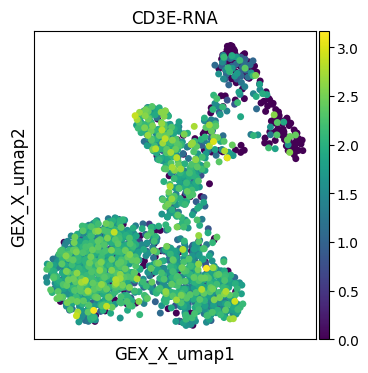

In [53]:
# marker for pan T-cell
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="GEX_X_umap", color="CD3E-RNA", size=100,
                    save="_Tcells_GEX_CD3E-RNA.pdf")

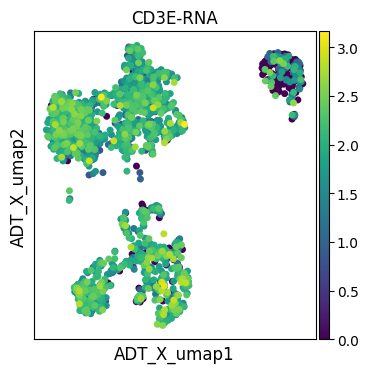

In [52]:
# marker for pan T-cell
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="ADT_X_umap", color="CD3E-RNA", size=100,
                    save="_Tcells_ADT_CD3E-RNA.pdf")

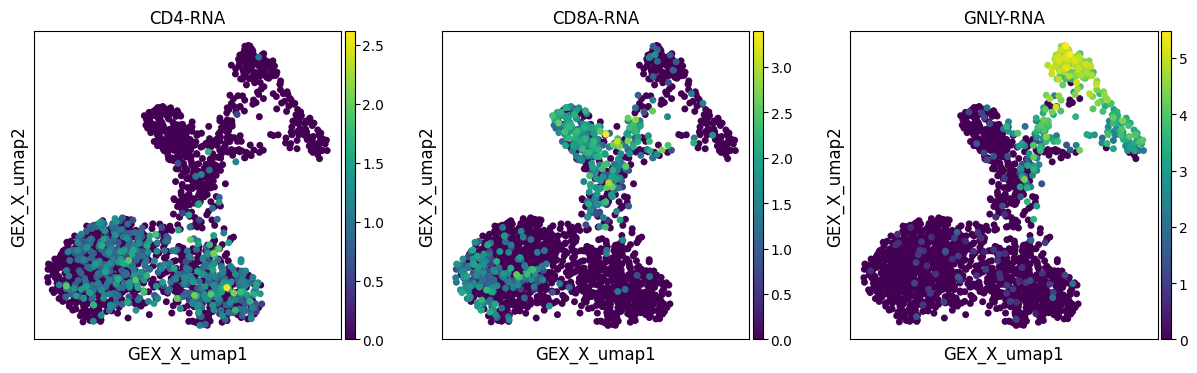

In [51]:
# marker genes for T cell subtypes (CD4, CD8A, GNLY, for CD4 T, CD8 T, or NK cells, respectively)
# RNA(GEX) UMAP
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="GEX_X_umap", color=["CD4-RNA","CD8A-RNA","GNLY-RNA"], size=100, ncols=3,
                    save="_Tcells_GEX_Tcell_subtype_RNA_markers.pdf")

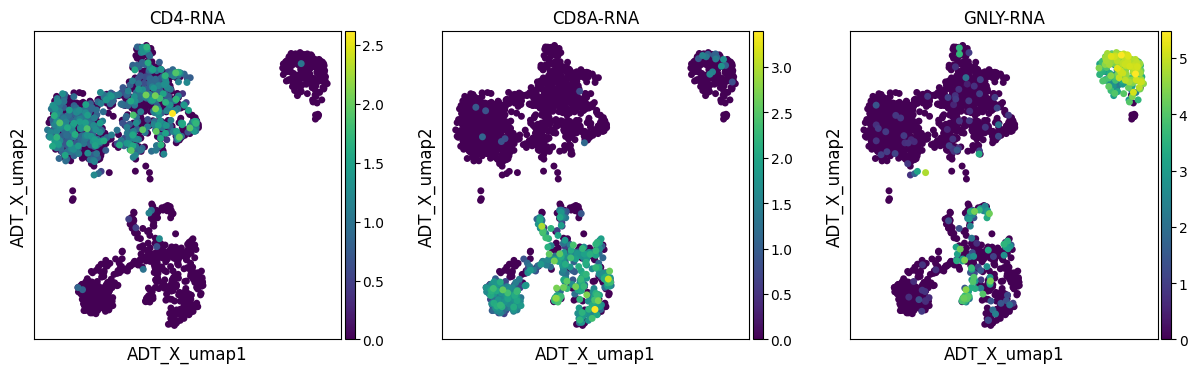

In [55]:
# marker genes for T cell subtypes (CD4, CD8A, GNLY, for CD4 T, CD8 T, or NK cells, respectively)
# ADT UMAP
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="ADT_X_umap", color=["CD4-RNA","CD8A-RNA","GNLY-RNA"], size=100, ncols=3,
                    save="_Tcells_ADT_Tcell_subtype_RNA_markers.pdf")

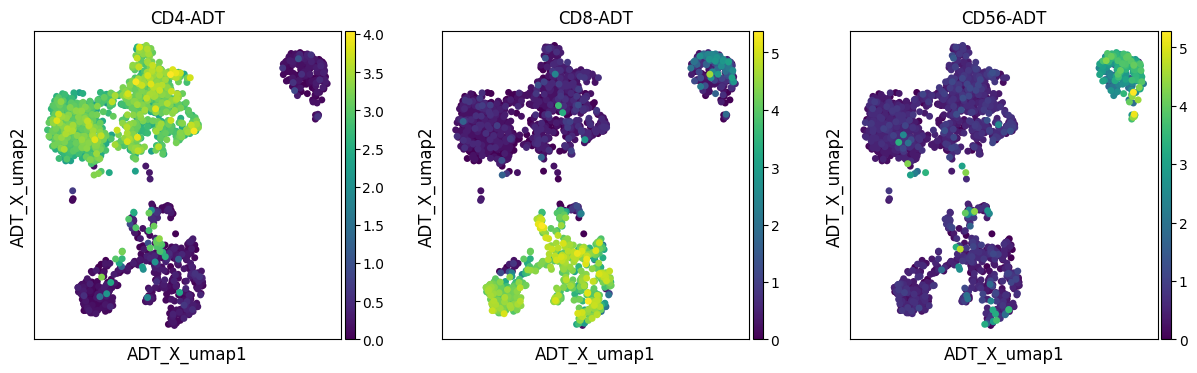

In [54]:
# marker "surface proteins" for T cell subtypes (CD4, CD8, CD56, for CD4 T, CD8 T, or NK cells, respectively)
# ADT UMAP
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="ADT_X_umap", color=["CD4-ADT","CD8-ADT","CD56-ADT"], size=100, ncols=3,
                    save="_Tcells_ADT_Tcell_subtype_ADT_markers.pdf")

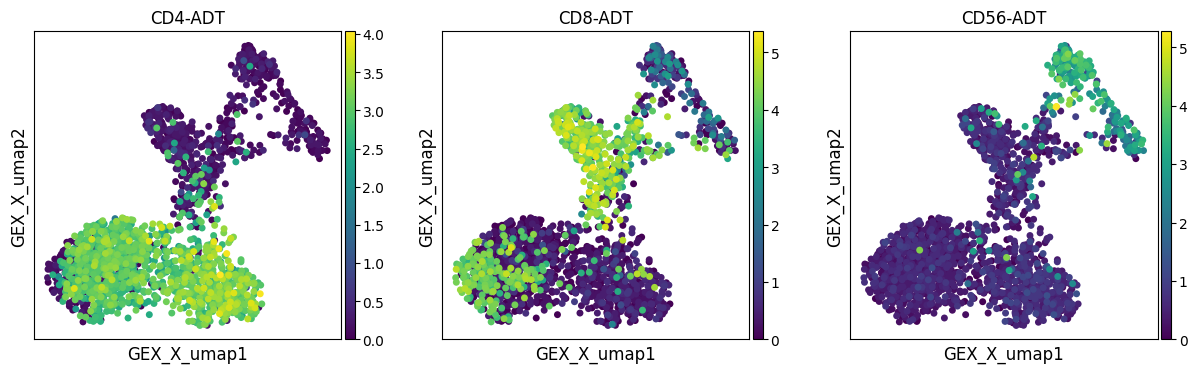

In [56]:
# marker "surface proteins" for T cell subtypes (CD4, CD8, CD56, for CD4 T, CD8 T, or NK cells, respectively)
# RNA(GEX) UMAP
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="GEX_X_umap", color=["CD4-ADT","CD8-ADT","CD56-ADT"], size=100, ncols=3,
                    save="_Tcells_GEX_Tcell_subtype_ADT_markers.pdf")

# Correlation between RNA and ADT expression levels

- With CITE-seq, one of the appeals is that we can identify cell-types with more markers, thus we can be more accurate about call-type annotation.
- one idea we would like to visit here is the correlation between the RNA and protein (ADT) markers, as we'd expect there to be a good correlation between these two modalities. So, by examining a 2D scatter plot with histograms for each modality could help us fine-tune our annotation based on the expression level of the markers.

In [121]:
# extract the count matrix (cells x (RNA+ADT), normalized for each modality independently with each other.)
df = pd.DataFrame(index=adata.obs_names,
                  columns=adata.var_names,
                  data = adata.X.todense())
df

AL627309.5-RNA  LINC01409-RNA  LINC01128-RNA  \
GCATTAGCATAAGCGG-1-s1d1             0.0            0.0       0.000000   
TACAGGTGTTAGAGTA-1-s1d1             0.0            0.0       0.000000   
AGGATCTAGGTCTACT-1-s1d1             0.0            0.0       0.000000   
GTAGAAAGTGACACAG-1-s1d1             0.0            0.0       0.000000   
TCCGAAAAGGATCATA-1-s1d1             0.0            0.0       0.000000   
...                                 ...            ...            ...   
GTCGAATAGTTTCGGT-1-s1d1             0.0            0.0       0.000000   
AGTAGTCTCTGGGCGT-1-s1d1             0.0            0.0       0.000000   
GCCCGAAGTATGGAGC-1-s1d1             0.0            0.0       0.000000   
CTACATTAGCGCGTTC-1-s1d1             0.0            0.0       0.000000   
GATTCTTTCACCCATC-1-s1d1             0.0            0.0       0.415616   

                         LINC00115-RNA  FAM41C-RNA  NOC2L-RNA  KLHL17-RNA  \
GCATTAGCATAAGCGG-1-s1d1            0.0         0.0   0.000000         0.0   
TACAGGTGTTAGAGTA-1-s1d1            0.0         0.0   0.000000         0.0   
AGGATCTAGGTCTACT-1-s1d1            0.0         0.0   0.000000         0.0   
GTAGAAAGTGACACAG-1-s1d1            0.0         0.0   0.000000         0.0   
TCCGAAAAGGATCATA-1-s1d1            0.0         0.0   0.000000         0.0   
...                                ...         ...        ...         ...   
GTCGAATAGTTTCGGT-1-s1d1            0.0         0.0   0.000000         0.0   
AGTAGTCTCTGGGCGT-1-s1d1            0.0         0.0   0.000000         0.0   
GCCCGAAGTATGGAGC-1-s1d1            0.0         0.0   0.895706         0.0   
CTACATTAGCGCGTTC-1-s1d1            0.0         0.0   0.000000         0.0   
GATTCTTTCACCCATC-1-s1d1            0.0         0.0   0.000000         0.0   

                         HES4-RNA  ISG15-RNA  AGRN-RNA  ...  CD94-ADT  \
GCATTAGCATAAGCGG-1-s1d1       0.0   0.000000       0.0  ...  0.151638   
TACAGGTGTTAGAGTA-1-s1d1       0.0   0.000000       0.0  ...  0.905696   
AGGATCTAGGTCTACT-1-s1d1       0.0   0.000000       0.0  ...  0.151638   
GTAGAAAGTGACACAG-1-s1d1       0.0   0.000000       0.0  ...  0.000000   
TCCGAAAAGGATCATA-1-s1d1       0.0   0.000000       0.0  ...  0.503775   
...                           ...        ...       ...  ...       ...   
GTCGAATAGTTTCGGT-1-s1d1       0.0   0.000000       0.0  ...  0.000000   
AGTAGTCTCTGGGCGT-1-s1d1       0.0   0.000000       0.0  ...  0.151638   
GCCCGAAGTATGGAGC-1-s1d1       0.0   0.000000       0.0  ...  1.086833   
CTACATTAGCGCGTTC-1-s1d1       0.0   0.000000       0.0  ...  0.763687   
GATTCTTTCACCCATC-1-s1d1       0.0   0.415616       0.0  ...  0.503775   

                         CD162-ADT  CD85j-ADT  CD23-ADT  CD328-ADT  HLA-E-ADT  \
GCATTAGCATAAGCGG-1-s1d1   0.275544   0.357243  0.802581   0.212457   0.531909   
TACAGGTGTTAGAGTA-1-s1d1   2.097850   1.552089  1.514912   3.195998   1.069881   
AGGATCTAGGTCTACT-1-s1d1   0.242905   0.619913  0.769582   0.000000   0.765012   
GTAGAAAGTGACACAG-1-s1d1   1.227028   0.357243  0.254422   3.466028   0.568724   
TCCGAAAAGGATCATA-1-s1d1   0.156318   0.827744  0.700126   0.000000   0.604232   
...                            ...        ...       ...        ...        ...   
GTCGAATAGTTTCGGT-1-s1d1   0.322588   0.999725  0.834526   0.212457   0.794283   
AGTAGTCTCTGGGCGT-1-s1d1   0.950203   0.539786  0.501903   0.387590   1.069881   
GCCCGAAGTATGGAGC-1-s1d1   1.354899   0.133768  0.501903   0.212457   0.929020   
CTACATTAGCGCGTTC-1-s1d1   2.432257   1.884336  1.360248   3.466028   0.929020   
GATTCTTTCACCCATC-1-s1d1   0.138064   0.694094  0.360868   1.062536   0.765012   

                         CD82-ADT  CD101-ADT  CD88-ADT  CD224-ADT  
GCATTAGCATAAGCGG-1-s1d1  0.462102   0.056784  0.325123   0.312179  
TACAGGTGTTAGAGTA-1-s1d1  0.448301   2.254477  0.705340   2.360822  
AGGATCTAGGTCTACT-1-s1d1  1.259504   0.000000  0.325123   0.257057  
GTAGAAAGTGACACAG-1-s1d1  0.345970   0.496338  0.293797   3.481558  
TCCGAAAAGGATCATA-1-s1d1  0.214558

In [113]:
adata.obs.coarse_annotation

GCATTAGCATAAGCGG-1-s1d1                  unassigned
TACAGGTGTTAGAGTA-1-s1d1                  unassigned
AGGATCTAGGTCTACT-1-s1d1                  unassigned
GTAGAAAGTGACACAG-1-s1d1                     T cells
TCCGAAAAGGATCATA-1-s1d1    erythroblast_development
                                     ...           
GTCGAATAGTTTCGGT-1-s1d1                  unassigned
AGTAGTCTCTGGGCGT-1-s1d1                     T cells
GCCCGAAGTATGGAGC-1-s1d1                     T cells
CTACATTAGCGCGTTC-1-s1d1                  unassigned
GATTCTTTCACCCATC-1-s1d1                  unassigned
Name: coarse_annotation, Length: 5227, dtype: category
Categories (3, object): ['T cells', 'erythroblast_development', 'unassigned']

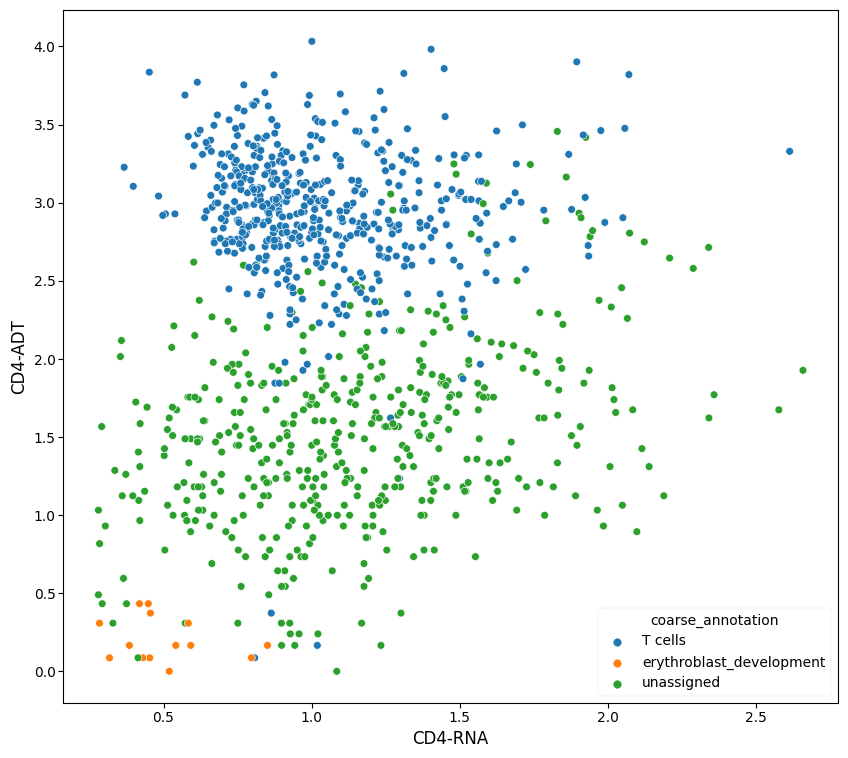

In [114]:
plt.rc_context({"figure.figsize": (4,4), "figure.dpi": (100)})

df_filtered = df[df["CD4-RNA"]!=0]
sns.scatterplot(data=df_filtered,
                x="CD4-RNA",
                y="CD4-ADT", hue=adata.obs.coarse_annotation)
# sns.scatterplot(data=df_filtered[adata.obs.coarse_annotation=="T cells"],
#                 x="CD4-RNA",
#                 y="CD4-ADT")
# sns.scatterplot(data=df_filtered[adata.obs.manual_annotation.isin(["CD4+ T activated","CD4+ T naive"])],
#                 x="CD4-RNA",
#                 y="CD4-ADT")
plt.show()


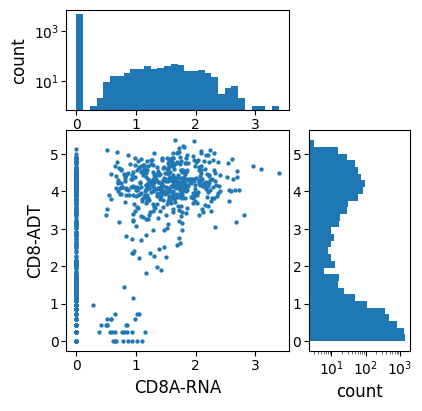

In [214]:
import matplotlib.gridspec as gridspec

# filter out the cells with zero-values?
# df_filtered = df[df["CD8-RNA"]!=0]

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.scatter(df["CD8A-RNA"],df["CD8-ADT"],marker='.')
ax_main.set(xlabel="CD8A-RNA", ylabel="CD8-ADT")

ax_xDist.hist(df["CD8A-RNA"],bins=30,align='mid')
ax_xDist.set(ylabel='count',yscale="log")


ax_yDist.hist(df["CD8-ADT"],bins=30,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count',xscale="log")


# plt.show()
plt.savefig(figpath+"scatter_hist_CD8_RNA_ADT.pdf", dpi=200, format="pdf")
plt.show()

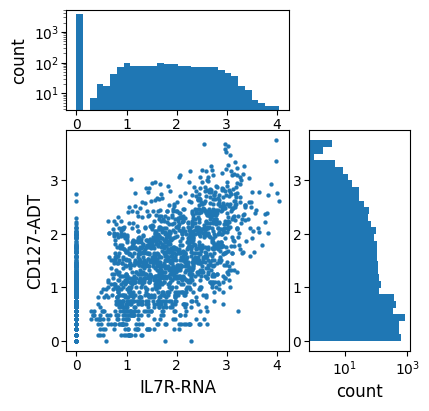

In [143]:
# Check the IL7R-RNA and CD127-ADT (gene that encodes this surface protein)

# filter out the cells with zero-values?
# df_filtered = df[df["CD8-RNA"]!=0]
RNA = "IL7R-RNA"
ADT = "CD127-ADT"

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.scatter(df[RNA],df[ADT],marker='.')
ax_main.set(xlabel=RNA, ylabel=ADT)

ax_xDist.hist(df[RNA],bins=30,align='mid')
ax_xDist.set(ylabel='count',yscale="log")


ax_yDist.hist(df[ADT],bins=30,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count',xscale="log")


# plt.show()
plt.savefig(figpath+"scatter_hist_IL7R_RNA_CD56_ADT.pdf", dpi=200, format="pdf")
plt.show()

## TO-DO

- Check the correlation coefficients between dozens of known pairs of RNA and ADT (For this, we might need to make a dictionary matching RNA and ADT manually...)-> Is there a better way of doing this more systematically? or a package that already does this? ChatGPT recommended BioMart package for this querying.


- Another idea is to assess the correlation coefficients between random pairs of RNA and ADT (make sure that they don't match). For this, we can basically boostrap from the RNA feature space for ADT. Or, we can make this as a sampling problem where we apply certain thresholds for the level of expression of RNA (HVG, or above certain level, etc.)



In [144]:
adata.var

name_0 feature_types      mean  variance
AL627309.5-RNA  AL627309.5-RNA           GEX  0.009675  0.009166
LINC01409-RNA    LINC01409-RNA           GEX  0.040192  0.038703
LINC01128-RNA    LINC01128-RNA           GEX  0.088064  0.075881
LINC00115-RNA    LINC00115-RNA           GEX  0.013494  0.013121
FAM41C-RNA          FAM41C-RNA           GEX  0.017757  0.016687
...                        ...           ...       ...       ...
HLA-E-ADT            HLA-E-ADT           ADT  0.709792  0.108324
CD82-ADT              CD82-ADT           ADT  0.830147  0.366369
CD101-ADT            CD101-ADT           ADT  0.868571  0.678431
CD88-ADT              CD88-ADT           ADT  0.856834  0.574393
CD224-ADT            CD224-ADT           ADT  0.846354  0.599646

[14087 rows x 4 columns]

In [175]:
# generate a dictionary of {RNA:ADT} pair to compute the correlation coefficient more systematically for the ADT panel.
list_ADT_markers = adata.var_names[adata.var.feature_types=="ADT"].to_list()
list_ADT_markers

from biomart import BiomartServer

# Connect to the Ensembl BioMart server
server = BiomartServer("http://www.ensembl.org/biomart")

# Choose the Ensembl mart
mart = server.datasets['hsapiens_gene_ensembl']

# Set the parameters for the query
params = {
    "filters": {"external_gene_name": "IL7R"},
    "attributes": ["external_gene_name", "ensembl_gene_id"],
}

# Execute the query and retrieve the results
result = mart.search(params=params)

# Print the results
print(result)

# Retrieve the data as a string
data = result.content.decode("utf-8")

# Print the data
print(data)

<Response [200]>


In [187]:
# generate a dictionary of {RNA:ADT} pair to compute the correlation coefficient more systematically for the ADT panel.
list_ADT_markers = adata.var_names[adata.var.feature_types=="ADT"].to_list()
# strip out the -ADT from the string
list_ADT_markers = [x.replace("-ADT","") for x in list_ADT_markers]

# Initialize a list to store the results
results = []

# Loop over the list of ADT markers
for marker in list_ADT_markers:
    # Set the parameters for the query
    params = {
        "filters": {"external_gene_name": marker},
        "attributes": ["external_gene_name", "ensembl_gene_id"],
    }

    # Execute the query and retrieve the result
    result = mart.search(params=params)
    
    # Retrieve the data as a string
    data = result.content.decode("utf-8")
    
    # Append the result to the list of results
    results.append(data)

# Print the list of results
for result in results:
    print(result)

CD86	ENSG00000114013

CD274	ENSG00000120217




CD47	ENSG00000196776

CD48	ENSG00000117091

CD40	ENSG00000101017


CD52	ENSG00000169442




CD19	ENSG00000177455

CD33	ENSG00000105383





CD7	ENSG00000173762




CD4	ENSG00000010610

CD44	ENSG00000026508

CD14	ENSG00000170458





TIGIT	ENSG00000181847







CD5	ENSG00000110448






CD69	ENSG00000110848





KLRG1	ENSG00000139187

CD27	ENSG00000139193





CD1C	ENSG00000158481




CD1D	ENSG00000158473






CD58	ENSG00000116815


CX3CR1	ENSG00000168329

CD24	ENSG00000272398



CD79B	ENSG00000007312

CD244	ENSG00000122223














CD163	ENSG00000177575

CD83	ENSG00000112149



CD2	ENSG00000116824

CD226	ENSG00000150637




CD81	ENSG00000110651



CD28	ENSG00000178562

CD38	ENSG00000004468



CD22	ENSG00000012124




CD63	ENSG00000135404


CD36	ENSG00000135218


CD72	ENSG00000137101


CD93	ENSG00000125810




CD9	ENSG00000010278














HLA-E	ENSG00000206493
HLA-E	ENSG00000225201
HLA-E	ENSG00000236632
HLA-E	ENSG00000230254
HL

In [212]:
"".split("\t")[0]

''

In [213]:
dict_RNA_ADT = {}
index = 0

for ADT in list_ADT_markers:
    RNA = results[index].split("\t")[0]
    dict_RNA_ADT[index] = {RNA:ADT}
    index = index+1

dict_RNA_ADT

{0: {'CD86': 'CD86'},
 1: {'CD274': 'CD274'},
 2: {'': 'CD270'},
 3: {'': 'CD155'},
 4: {'': 'CD112'},
 5: {'CD47': 'CD47'},
 6: {'CD48': 'CD48'},
 7: {'CD40': 'CD40'},
 8: {'': 'CD154'},
 9: {'CD52': 'CD52'},
 10: {'': 'CD3'},
 11: {'': 'CD8'},
 12: {'': 'CD56'},
 13: {'CD19': 'CD19'},
 14: {'CD33': 'CD33'},
 15: {'': 'CD11c'},
 16: {'': 'HLA-A-B-C'},
 17: {'': 'CD45RA'},
 18: {'': 'CD123'},
 19: {'CD7': 'CD7'},
 20: {'': 'CD105'},
 21: {'': 'CD49f'},
 22: {'': 'CD194'},
 23: {'CD4': 'CD4'},
 24: {'CD44': 'CD44'},
 25: {'CD14': 'CD14'},
 26: {'': 'CD16'},
 27: {'': 'CD25'},
 28: {'': 'CD45RO'},
 29: {'': 'CD279'},
 30: {'TIGIT': 'TIGIT'},
 31: {'': 'CD20'},
 32: {'': 'CD335'},
 33: {'': 'CD31'},
 34: {'': 'Podoplanin'},
 35: {'': 'CD146'},
 36: {'': 'IgM'},
 37: {'CD5': 'CD5'},
 38: {'': 'CD195'},
 39: {'': 'CD32'},
 40: {'': 'CD196'},
 41: {'': 'CD185'},
 42: {'': 'CD103'},
 43: {'CD69': 'CD69'},
 44: {'': 'CD62L'},
 45: {'': 'CD161'},
 46: {'': 'CD152'},
 47: {'': 'CD223'},
 48: {'K

## gget to map ADT panels to genes



In [223]:
pip show gget

Name: gget
Version: 0.27.2
Summary: Efficient querying of genomic databases directly into programming environments.
Home-page: https://github.com/pachterlab/gget
Author: Laura Luebbert
Author-email: lauraluebbert@caltech.edu
License: BSD-2
Location: /home/yangjoon.kim/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages
Requires: beautifulsoup4, ipython, ipywidgets, matplotlib, mysql-connector-python, numpy, pandas, py3Dmol, requests, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [224]:
gget.search("IL7R","homo_sapiens")

Wed Feb  1 19:26:08 2023 INFO Fetching results from database: homo_sapiens_core_108_38
Wed Feb  1 19:26:10 2023 INFO Total matches found: 2.
Wed Feb  1 19:26:10 2023 INFO Query time: 6.89 seconds.


ensembl_id gene_name  \
0  ENSG00000168685      IL7R   
1           LRG_74      IL7R   

                                 ensembl_description     ext_ref_description  \
0  interleukin 7 receptor [Source:HGNC Symbol;Acc...  interleukin 7 receptor   
1  interleukin 7 receptor [Source:HGNC Symbol;Acc...  interleukin 7 receptor   

          biotype                                                url  
0  protein_coding  https://uswest.ensembl.org/homo_sapiens/Gene/S...  
1        LRG_gene  https://uswest.ensembl.org/homo_sapiens/Gene/S...

In [232]:
gget.info("ENSG00000168685")["synonyms"]

ENSG00000168685    [CD127, CDW127, IL-7R-alpha, IL7RA, ILRA, IMD1...
Name: synonyms, dtype: object

In [231]:
gget.pdb("CD127")

Wed Feb  1 19:33:30 2023 ERROR pdb for CD127 was not found. Please double-check arguments and try again.


In [222]:
# Define the protein name
protein_name = "CD127"

# Use gget to retrieve the gene information
gene_info = gget.get_gene(protein_name, source="uniprot")

# Extract the gene name from the result
gene_name = gene_info["gene"]

# Print the result
print(gene_name)

AttributeError: module 'gget' has no attribute 'get_gene'

In [219]:
import gget
gget.search("ACE2", "homo_sapiens")

Wed Feb  1 19:11:11 2023 INFO Fetching results from database: homo_sapiens_core_108_38
Wed Feb  1 19:11:13 2023 INFO Total matches found: 3.
Wed Feb  1 19:11:13 2023 INFO Query time: 4.03 seconds.


ensembl_id  gene_name  \
0  ENSG00000130234       ACE2   
1  ENSG00000182240      BACE2   
2  ENSG00000224388  BACE2-IT1   

                                 ensembl_description  \
0  angiotensin converting enzyme 2 [Source:HGNC S...   
1  beta-secretase 2 [Source:HGNC Symbol;Acc:HGNC:...   
2  BACE2 intronic transcript 1 [Source:HGNC Symbo...   

               ext_ref_description         biotype  \
0  angiotensin converting enzyme 2  protein_coding   
1                 beta-secretase 2  protein_coding   
2      BACE2 intronic transcript 1          lncRNA   

                                                 url  
0  https://uswest.ensembl.org/homo_sapiens/Gene/S...  
1  https://uswest.ensembl.org/homo_sapiens/Gene/S...  
2  https://uswest.ensembl.org/homo_sapiens/Gene/S...

In [221]:
gget.info("ENSG00000130234")

ensembl_id uniprot_id pdb_id ncbi_gene_id  \
ENSG00000130234  ENSG00000130234.13     Q9BYF1    NaN        59272   

                      species assembly_name primary_gene_name  \
ENSG00000130234  homo_sapiens        GRCh38              ACE2   

                ensembl_gene_name synonyms parent_gene  ...  \
ENSG00000130234              ACE2   [ACEH]         NaN  ...   

                                                  transcript_names  \
ENSG00000130234  [ACE2-208, ACE2-209, ACE2-210, ACE2-206, ACE2-...   

                                           transcript_strands  \
ENSG00000130234  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]   

                                                 transcript_starts  \
ENSG00000130234  [15494566, 15494566, 15518189, 15550715, 15557...   

                                                   transcript_ends all_exons  \
ENSG00000130234  [15600960, 15600960, 15600960, 15600960, 15580...       NaN   

                exon_starts exon_ends all_translations translation_starts  \
ENSG00000130234         NaN       NaN              NaN                NaN   

                translation_ends  
ENSG00000130234              NaN  

[1 rows x 34 columns]

## Check the erythroblast development population 

Better-resolved in RNA(GEX) than ADT(CITE)

# Combine all panels into one large figure

In [ ]:
# sc.set_figure_params(vector_friendly=True, dpi=300, dpi_save=2000)
# mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
# set_plotting_style_huge()

# fig2 = plt.figure(figsize=(20,26), constrained_layout=True) # Create figure
# subfigs = fig2.subfigures(5,1, height_ratios=[0.5, 0.5, 1, 1, 1]) # Create subfigures (each row)
# axes0 = subfigs[0].subplots(1,3) # Axes for the subfigure 1
# axes1 = subfigs[1].subplots(1,3) # Axes for the subfigure 2
# axes2 = subfigs[2].subplots(1,3) # Axes for the subfigure 3
# axes3 = subfigs[3].subplots(2,3) # Axes for the subfigure 4
# axes4 = subfigs[4].subplots(1,1) # Axes for the subfigure 5

# # # remove the underlying axes for the spatial panel and the last panel
# # gs = axes1[0,0].get_gridspec() #Get gridspecs
# # for i in [0,1]:
# #     for j in [0,1]:
# #         axes1[i,j].remove()
# # for i in [2]:
# #     for j in [0,1,2]:
# #         axes1[i,j].remove()

# # axbig1 = subfigs[1].add_subplot(gs[0:2, 0:2])
# # axbig2 = subfigs[1].add_subplot(gs[2, 0:2])
# # axbig3 = subfigs[1].add_subplot(gs[2, 2:4])

# # Panel A: UMAP
# ax = axes0[0]
# sc.pl.umap(adata, ax=ax, show=False, legend_loc='on data',
#            frameon=True, size=20)

# ax = axes0[1]
# sc.pl.umap(VizgenLiver, color='ptprb', ax=ax, show=False, legend_loc=None,
#           frameon=True, size=20)

# ax = axes0[2]
# sc.pl.umap(adata, color = "CD3E", ax=ax, show=False, legend_loc='on data',
#            frameon=True, size=20)


